In [1]:

import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from PID_Controller import PID
from CarParameters import CarParam
from SimulatedCarState import SimulatedCarState
from Control_Response_Evaluator import Control_Response_Evaluator

class CarController:
    speed_pid = PID()
    speed_pid.kp = 1.0 # 1.0 for pure P seemds to work well
    
    steer_pid = PID()
    steer_pid.kp = 0.5

In [293]:
class Steering_Controller:
    
    cross_track_error_gain = 0.1
    cross_track_error_soft = 1.0 # paper uses 1.0 m/s
    kd_yaw = 0.0 #TODO - tune
    kd_steer = 2.0 #TODO - tune - prevents overshoot on steerging, damping term
    
    
    def __init__(self):
        pass
    
    
    def tic(self, carParams, carState):
        '''Calculate desired steering angle'''
        yaw_angle_desired = 0.0
        yaw_rate_desired = 0.0 # r_meas
        cross_track_error = -carState.x[carState.yi]
        # print("cross_track_error: ", cross_track_error)
        # print("yaw_rate_error: ", (carState.get_heading_rate() - yaw_rate_desired))
        
        cross_track_error_correction = math.atan(self.cross_track_error_gain * cross_track_error / (self.cross_track_error_soft + carState.get_speed()))
        steady_state_yaw_angle = yaw_rate_desired * carState.get_speed() * carParams.mass / (carParams.c_y*(1 + carParams.a/carParams.b))
        # print("steady_state_yaw_angle: ", steady_state_yaw_angle)
        # print("yaw_error: ", (carState.get_heading_angle() - steady_state_yaw_angle))
        desired_steering_angle = ( (yaw_angle_desired - carState.get_heading_angle() - steady_state_yaw_angle) + 
                                cross_track_error_correction + 
                                self.kd_yaw * (yaw_rate_desired - carState.get_heading_rate()) + 
                                self.kd_steer * carState.get_steering_rate() )
        # prev_steer = 0.0
        # current_steer = 0.0
        # desired_steering_angle = (desired_yaw_angle - steady_state_yaw_angle) + cross_track_error_correction + self.kd_yaw * (carState.get_heading_rate() - yaw_rate_desired) + self.kd_steer * (prev_steer - current_steer)
        return desired_steering_angle, cross_track_error_correction       

controller performance::rise_time:  1.2000000000000008  s
controller performance::overshoot:  409.87805410725286 %
controller performance::settling_time:  0.0  s


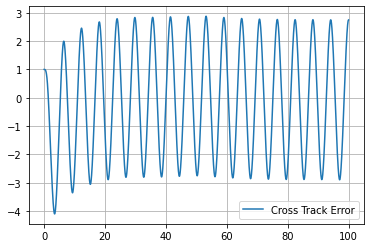

In [294]:
# check the ability to control the car's steering
dt = 0.01
x = np.array([0, #0 - x position
                0, #1 - x speed
              1.0, #2 - y position
                0, #3 - y speed 
              5.0, #4 - forward speed
                0, #5 - forward acceleration
                0, #6 - forward jerk
                0, #7 - heading angle
                0, #8 - heading rate
                0, #9 - steering angle
                0]) #10 - steering rate
carParams = CarParam()
car = SimulatedCarState(x, carParams)
steer_control = Steering_Controller()

#i think the correct answer is to add the cross track error term onto the existing steering PID controller


times = []
ctecs = []
sds = []
sas = []
srs = []
has = []
hrs = []
xs = []
xds = []
ys = []
yds = []

t = 0.0
while t < 100.0:
    times.append(t)
    sas.append(car.x[car.sai])
    srs.append(car.x[car.sri])
    has.append(car.x[car.hai])
    hrs.append(car.x[car.hri])
    xs.append(car.x[car.xi])
    xds.append(car.x[car.xdi])
    ys.append(car.x[car.yi])
    yds.append(car.x[car.ydi])
    
    # steer_des = controller.steer_pid.tic(car.x[car.hai], heading_des)
    steer_des, ctec = steer_control.tic(carParams, car)
    ctecs.append(ctec)
    sds.append(steer_des)
    car.input_steering(steer_des)
    car.tic(dt)
    t += dt
    
cer = Control_Response_Evaluator()
[rise_time, overshoot, settling_time] = cer.evaluate_performance(times, ys, 0.0)
print("controller performance::rise_time: ", rise_time, " s")
print("controller performance::overshoot: ", overshoot * 100.0, "%")
print("controller performance::settling_time: ", settling_time, " s")

plt.plot(times, ys, label='Cross Track Error')
plt.legend()
plt.grid()
plt.show()

# plt.plot(times, has, label='Heading Angle')
# plt.plot(times, hrs, label='Heading Rate')
# plt.legend()
# plt.grid()
# plt.show()

# plt.plot(times, sas, label='Steering Angle')
# plt.plot(times, srs, label='Steering Rate')
# plt.plot(times, sds, label='Desired Steering Angle')
# plt.plot(times, ctecs, label='Cross Track Error Correction')
# plt.legend()
# plt.grid()
# plt.show()

# plt.plot(xs, ys, label='Position')
# plt.axis('equal')
# plt.legend()
# plt.grid()
# plt.show()

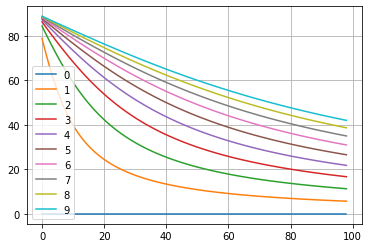

In [295]:
# testing the cross track error term - this works as expected
### going faster makes you turn less
### larger error makes you turn more
### bigger soft term makes you turn less
### bigger gain makes you turn more

cross_track_error_gain = 10.0
cross_track_error = 1.0
cross_track_error_soft = 1.0

for s in range(10):
    cross_track_error = s
    ctec = []
    for speed in range(1,100):
        ctec.append(math.degrees(math.atan(cross_track_error_gain * cross_track_error / (cross_track_error_soft + speed))))
        
    plt.plot(ctec, label=str(cross_track_error))
        
plt.grid()
plt.legend()
plt.show()

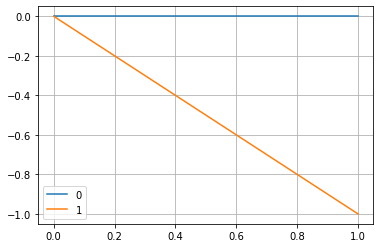

In [296]:
# testing the yaw rate term

yaw_rate_desired = 0.0
yaw_rate = 1.0
kd_yaw_rate = 0.0

for kd_yaw_rate in range(2):
    
    yrct = []
    for yaw_rate in range(2):
        yrct.append(kd_yaw_rate * (yaw_rate_desired - yaw_rate))
    plt.plot(yrct, label=str(kd_yaw_rate))
        
plt.grid()
plt.legend()
plt.show()
